### 引入相關python模組

In [1]:
from mycnn import ResNet50
from mycnn import utils
import tensorflow as tf
import numpy as np

### 使用Keras API來建立Dataset實例

利用Keras API中的`preprocessing`模組的`image_dataset_from_directory`  
用此函數來建立貓狗的資料集，此函數將會回傳`tf.data.Dataset`的實例  
接著使用`map`函式來重新縮放(正規化)資料區間至 [0, 1]

#### tf.keras.preprocessing.image_dataset_from_directory

```
參數名稱            型態    說明
directory        : str   : 資料路徑 (子資料夾為類別)
image_size       : tuple : 影像大小
batch_size       : int   : 批次大小
label_mode       : str   : 標記模式 "categorical" (註:其他模式需要修改loss函數)
validation_split : float : 分離驗證集的比例
subset           : str   : 選擇訓練集 "training"、驗證集 "validation"
seed             : int   : 亂數種子
```

In [2]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(224,224),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=10
)
train_dataset.map(lambda x, y: (x/255., y))


valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(224,224),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
valid_dataset.map(lambda x, y: (x/255., y))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


<MapDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

### 載入ResNet50模型

```
參數名稱       型態    說明
input_shape : tuple : 輸入影像形狀
classes_num : int   : 輸出類別數量
```

In [3]:
resnet50 = ResNet50(classes_num=2)
resnet50.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 230, 230, 3)       0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 64)      256       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 64)      0         
_________________________________________________________________
pool_pad (ZeroPadding2D)     (None, 114, 114, 64)      0         
_________________________________________________________________
pool (MaxPooling2D)          (None, 56, 56, 64)        0  

### 配置訓練參數

```
參數名稱      型態                         說明
logdir     : str                        : 儲存路徑
epochs     : int                        : 訓練次數
batch_size : int                        : 批次大小 (註:此設定需與image_dataset_from_directory的批次大小一致)
optimizer  : str or tf.keras.optimizers : 優化函數
loss       : str or tf.keras.loss       : 損失函數
metrics    : list                       : 評估函數清單
```

In [4]:
resnet50.setup_training(
    'log_resnet50',
    epochs=10,
    batch_size=20,  # batch size depend on `image_dataset_from_directory`
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
resnet50.add_callback(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, patience=2,
        min_lr=0.00001,
        verbose=1
    )
)

[Info] Create new the directory for training log !!!!!
******************************
Training new model...
******************************
checkpoint_path : log_resnet50\weights
best_checkpoint : log_resnet50\weights.h5
epochs          : 10
initial_epoch   : 0
batch_size      : 20
optimizer       : <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x000001A438713388>
loss            : categorical_crossentropy
metrics         : ['accuracy']


### 開始訓練

輸入參數分別為訓練資料集、驗證資料集的實例

In [5]:
resnet50.train_dataset(train_dataset, valid_dataset)

Epoch 1/10
1000/1000 [==============================] - 581s 569ms/step - loss: 0.7350 - accuracy: 0.5825 - val_loss: 0.7358 - val_accuracy: 0.6010

Epoch 00001: val_loss improved from inf to 0.73576, saving model to log_resnet50\weights.h5
Epoch 2/10
1000/1000 [==============================] - 616s 615ms/step - loss: 0.6199 - accuracy: 0.6657 - val_loss: 0.6983 - val_accuracy: 0.6548

Epoch 00002: val_loss improved from 0.73576 to 0.69832, saving model to log_resnet50\weights.h5
Epoch 3/10
1000/1000 [==============================] - 627s 627ms/step - loss: 0.5536 - accuracy: 0.7226 - val_loss: 0.5426 - val_accuracy: 0.7188

Epoch 00003: val_loss improved from 0.69832 to 0.54258, saving model to log_resnet50\weights.h5
Epoch 4/10
1000/1000 [==============================] - 621s 621ms/step - loss: 0.4853 - accuracy: 0.7697 - val_loss: 0.7183 - val_accuracy: 0.6648

Epoch 00004: val_loss did not improve from 0.54258
Epoch 5/10
1000/1000 [==============================] - 571s 570ms/st

### 繪製訓練過程曲線

可以用來確認權重是否有收斂的趨勢、檢查是否有過擬合狀況

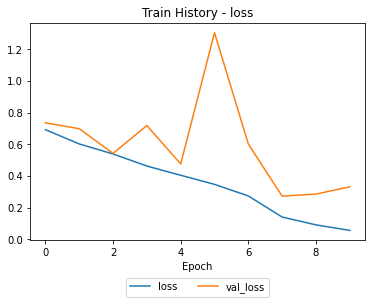

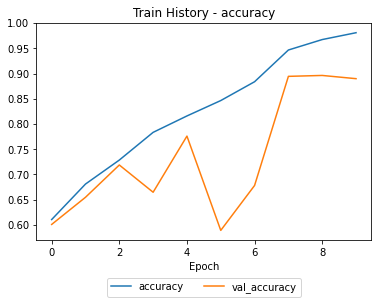

In [9]:
resnet50.show_history(["loss", "accuracy"])

### 使用測試資料來確認模型對於新資料的效能

In [10]:
resnet50.eval_dataset(valid_dataset)

250/250 [==============================] - 40s 157ms/step - loss: 0.3312 - accuracy: 0.8898


[0.33123263716697693, 0.8898000121116638]

### 使用confusion matrix來更進一步確認分類性能

- 預測測試資料的分數 (基於softmax函數計算機率分布)
- 使用`argmax`將分數轉成類別ID
- 輸出分類報告 (印出confusion matrix、分類報告；輸出完整報表)
- 繪製confusion matrix，分為recall、precision

> Note:  
recall: 召回率，在所有GT中，真正預測出TP的指標  
precision: 精確率，在所有預測結果中，真正為TP的指標  
(GT: 真實情況；TP: 正樣本)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


100%|██████████| 5000/5000 [00:00<00:00, 227146.42it/s]


[[2269  224]
 [ 327 2180]] 

              precision    recall  f1-score   support

        Cats       0.87      0.91      0.89      2493
        Dogs       0.91      0.87      0.89      2507

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000
 



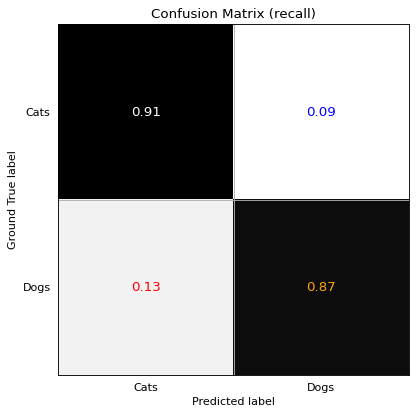

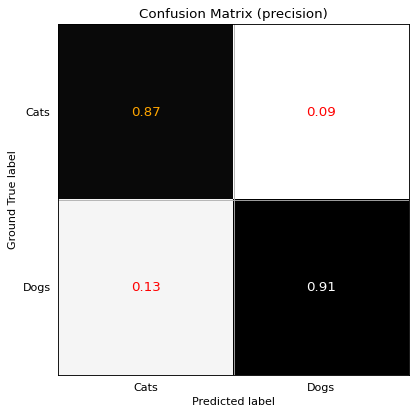

In [11]:
pred_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(224,224),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
pred_dataset.map(lambda x, y: (x/255., y))

pr_score = None
pr_label = None
gt_label = None
for ind, batch_set in enumerate(pred_dataset):
    batch_im, batch_gt = batch_set
    batch_pr = resnet50.pred(batch_im.numpy())
    if ind == 0:
        pr_score = batch_pr
        pr_label = batch_pr.argmax(axis=-1)
        gt_label = batch_gt.numpy().argmax(axis=-1)
    else:
        pr_score = np.concatenate([pr_score, batch_pr])
        pr_label = np.concatenate([pr_label, batch_pr.argmax(axis=-1)])
        gt_label = np.concatenate([gt_label, batch_gt.numpy().argmax(axis=-1)])

target_names = ["Cats", "Dogs"]

report = utils.export_classification_report(
    gt_label, pr_label, pr_score,
    target_names=target_names,
    logpath=resnet50.logdir
)

cm = report["confusion_matrix"]
cm_precision = cm/cm.sum(axis=0)
cm_recall = cm/cm.sum(axis=1)
utils.plot_confusion_matrix(cm_recall, target_names, resnet50.logdir, title='Confusion Matrix (recall)')
utils.plot_confusion_matrix(cm_precision, target_names, resnet50.logdir, title='Confusion Matrix (precision)')